## The Titanic Spaceship problem 

### Problem description
This machine learning problem involves predicting which passengers were transported to an alternate dimension during a spacetime anomaly involving the Spaceship Titanic. Given historical passenger data recovered from the damaged ship's computer system, the task is to build a classification model that accurately predicts the transport status of each passenger. 

### Machine Learning Model Evaluation and Results

This notebook explores the performance of different machine learning models, including **Random Forest**, **LightGBM**, and a **Stacking Classifier**, on a classification task. The evaluation focuses on train accuracy, test accuracy, Kaggle scores, and confusion matrices to assess model performance.

#### Key Results

1. **RandomForestClassifier**:
   - **Train Accuracy**: 0.98
   - **Test Accuracy**: 0.80
   - **Kaggle Score**: 0.78466
   - Demonstrates high training accuracy but slightly lower test accuracy, indicating possible overfitting.

2. **LightGBMClassifier**:
   - Optimized with efficient multi-threading and boosting techniques.
   - Provides robust performance by leveraging 27 features with balanced handling of positive and negative samples.
   - Auto-selects optimal configurations for resource efficiency and model accuracy.

3. **StackingClassifier**:
   - Combines the strengths of **Random Forest** and **LightGBM** using **Logistic Regression** as the final estimator.
   - **Train Accuracy**: 0.94
   - **Test Accuracy**: 0.81
   - **Kaggle Score**: 0.80757
   - Achieves the best test accuracy and Kaggle score, demonstrating improved generalization and reduced overfitting.

#### Summary
- The **RandomForestClassifier** provides strong individual performance with high training accuracy but shows slight overfitting.
- The **LightGBMClassifier** is highly efficient in handling large datasets and delivers balanced accuracy.
- The **StackingClassifier** outperforms the individual models, achieving the highest test accuracy and Kaggle score, highlighting the benefits of ensemble learning.



### Packages
- **pandas, numpy**: Data manipulation and numerical operations.
- **train_test_split**: Splits dataset for training/testing.
- **LabelEncoder, StandardScaler**: Converts categorical labels, scales features.
- **RandomForestClassifier, GradientBoostingClassifier, XGBClassifier, StackingClassifier**: Ensemble classifiers for prediction.
- **LogisticRegression**: Linear classifier.
- **matplotlib.pyplot**: Data visualization.
- **Keras (Dense, Dropout, BatchNormalization, EarlyStopping, Adam, Sequential)**: Builds and trains neural networks.
- **KNNImputer**: Imputes missing values.
- **accuracy_score, classification_report**: Evaluates classification metrics.
- **GridSearchCV**: Hyperparameter tuning.


In [27]:
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier,  StackingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import  make_scorer, f1_score, accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV

In [28]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### Explore data
The functions here help in preparing and analyzing a dataset, which are crucial steps in solving a machine learning problem effectively:

##### 1. Balance of the target varible 
This function checks the balance of the target variable in the dataset.
 A balanced target variable is important for classifictaion machine learning models to perform well. If the target is imbalanced, it may lead to biased predictions, and additional techniques like resampling or adjusting class weights may be needed. Fortunately, this data set has a good balance of the target variable

##### 2. Check for and fill missing values
This functions checks for missing values in the dataset. It uses `isnull().sum()` to calculate the number of missing values in each column and returns only those columns with missing values greater than zero. This is useful for identifying columns that need imputation or cleaning. Missing values can significantly affect the performance of machine learning models.
- **Categorical Columns**: Fills missing values with the most common value (`mode`) for columns like `HomePlanet`, `CryoSleep`, etc.
- **Numerical Columns**: Fills missing values with the median for columns like `Age`, `RoomService`, etc.

Identifying columns with missing values allows for proper handling, ensuring the model is trained on complete and accurate data, which reduces the risk of biased or erroneous predictions. Filling categorical columns with the mode and numerical columns with the median helps preserve the distribution of data and reduces the likelihood of introducing bias. This ensures that the dataset is complete, which helps the model generalize better and produce more accurate predictions.


In [29]:
def check_target_balance(data, target_column):
    """
    Check the balance of the target variable.
    """
    target_balance = data[target_column].value_counts(normalize=True)
    return target_balance

def check_missing_values(data):
    """
    Check for missing values in the dataset.
    """
    missing_values = data.isnull().sum()
    return missing_values[missing_values > 0]

def fill_missing_values(df):
    df.fillna({
        "CryoSleep": df["CryoSleep"].mode()[0],
        "Cabin": "np.nan/np.nan/np.nan",
        "Age": df["Age"].median(),
        "HomePlanet": df["HomePlanet"].mode()[0],
        "Destination": df["Destination"].mode()[0]
    }, inplace=True)
    return df

### KNN imputing
Attempting to use  K-Nearest Neighbors (KNN) Imputation to fill missing values in a dataset. This method is more advanced than using mean, median, or mode. (didn`t end up using this)
##### How It Works
Encode Categorical Variables: Categorical columns are temporarily encoded into numbers.
KNN Imputation: KNNImputer fills missing values based on similar data points (n_neighbors=5).
Reverse Encoding: Categorical columns are decoded back to their original labels.
##### Advantages
More Accurate: Uses data similarity for better estimates compared to simple imputation.
Handles Mixed Data: Works for both categorical and numerical columns.
Maintains Relationships: Preserves relationships between features, improving model consistency.

Here is more details on KNN imputation (: , https://medium.com/@kyawsawhtoon/a-guide-to-knn-imputation-95e2dc496e.

In [30]:
  # def fill_missing_values_with_knn(data, categorical_columns, n_neighbors=5):
#     """
#     Impute missing values for both categorical and numerical variables using KNN Imputation.
#     
#     Parameters:
#     - data: The dataframe with missing values.
#     - categorical_columns: List of categorical column names.
#     - n_neighbors: Number of neighbors to use for KNN imputation (default is 5).
#     
#     Returns:
#     - data: The dataframe with imputed missing values.
#     """
#     # Create a copy of the data to avoid altering the original dataset
#     data_copy = data.copy()
# 
#     # Temporarily encode categorical variables using LabelEncoder
#     label_encoders = {}
#     for col in categorical_columns:
#         le = LabelEncoder()
#         data_copy[col] = le.fit_transform(data_copy[col].astype(str))
#         label_encoders[col] = le
# 
#     # Apply KNNImputer for both categorical and numerical columns
#     knn_imputer = KNNImputer(n_neighbors=n_neighbors)
#     imputed_data = pd.DataFrame(knn_imputer.fit_transform(data_copy), columns=data_copy.columns)
# 
#     # Reverse the encoding for categorical variables
#     for col in categorical_columns:
#         imputed_data[col] = imputed_data[col].round().astype(int)
#         imputed_data[col] = label_encoders[col].inverse_transform(imputed_data[col])
# 
#     return imputed_data

### Standadise data
The standardize_numerical_columns function standardizes numerical columns in a dataset using z-score normalization. This process ensures that each numerical column has a mean of 0 and a standard deviation of 1, which is beneficial for many machine learning models that perform better when features are on a similar scale.
##### How It Works
Select Numerical Columns: The function standardizes columns such as Age, RoomService, FoodCourt, etc.\
Data Copy: A copy of the original dataset is created to avoid modifying the original data.
Standard Scaling: The function uses StandardScaler from scikit-learn to transform the numerical columns to a standardized scale.
##### Advantages
Improves Model Performance: Many machine learning algorithms, such as gradient descent-based models, work better when features are on a similar scale.
Handles Outliers: Z-score normalization reduces the impact of outliers, making the model more stable.

In [31]:
def scale_data(train_data, test_data):
    # Select only numeric columns for scaling
    numeric_cols = train_data.select_dtypes(include=[np.number]).columns
    scaler = StandardScaler()
    train_data[numeric_cols] = scaler.fit_transform(train_data[numeric_cols])
    test_data[numeric_cols] = scaler.transform(test_data[numeric_cols])
    return train_data, test_data

### Feature Engineering
The feature_engineering function performs transformations on the dataset to create new features and enhance existing ones. Feature engineering is crucial for improving the predictive power of machine learning models.

##### Key Transformations
1. Group and Travel Features: Creates Group, Group_Size, and Travelling_Solo features to capture group dynamics.
2. Cabin Details: Splits Cabin into Cabin_Deck, Cabin_Number, and Cabin_Side for detailed cabin information.
3. Expenditure Features: Aggregates spending into Total_Expenditure, flags No_Spending, and categorizes expenditures into levels.
4. Age Grouping: Categorizes Age into bins like 0-12, 13-18, etc., for better age-based patterns.
5. Name Parsing: Splits Name into FirstName and Surname for granular details.
##### Advantages
1. Enhanced Model Features: These transformations help machine learning models identify underlying relationships better by providing new and more informative features.
2. Improved Interpretability: Features like AgeGroup and TotalSpend improve interpretability by categorizing continuous data and summarizing spending behavior.

In [32]:
def check_cadinality(train_df, test_df):
    print("cardinality of categorical features in training datasets is:")
    print(train_df.select_dtypes(include="object").nunique())
    print("\n","-"*70)
    print("\nCardinality of categorical features in testing datsets is:")
    print(test_df.select_dtypes(include="object").nunique())

def feature_engineering(df):
    df["Group"] = df["PassengerId"].apply(lambda x: x.split("_")[0])
    df["Group_Size"] = df.groupby("Group")["PassengerId"].transform("count")
    df["Travelling_Solo"] = df["Group_Size"] == 1
    df["Cabin_Deck"] = df["Cabin"].apply(lambda x: x.split("/")[0])
    df["Cabin_Number"] = df["Cabin"].apply(lambda x: x.split("/")[1]).fillna(df["Cabin"].mode()[0])
    df["Cabin_Side"] = df["Cabin"].apply(lambda x: x.split("/")[2])
    df["Total_Expenditure"] = df[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]].sum(axis=1)
    df["No_Spending"] = df["Total_Expenditure"] == 0
    df["Expenditure_Category"] = pd.cut(df["Total_Expenditure"], bins=[-1, 0, 716, 1441, np.inf],
                                        labels=["No Expense", "Low", "Medium", "High"])
    df["Age_Group"] = pd.cut(df["Age"], bins=[0, 12, 18, 25, 32, 50, np.inf],
                             labels=["0-12", "13-18", "19-25", "26-32", "33-50", "50+"])
    
    # Ensure 'Name' column contains strings and handle missing values
    df['Name'] = df['Name'].astype(str).fillna('Unknown Unknown')
    
    # Split 'Name' into 'FirstName' and 'Surname'
    name_split = df['Name'].str.split(' ', n=1, expand=True)
    df['FirstName'] = name_split[0]
    df['Surname'] = name_split[1].fillna('Unknown')
    
    return df.drop(["Cabin", "PassengerId"], axis=1)

### Categorical variables encoding
The encode_categorical_features function encodes categorical columns in the dataset using LabelEncoder. This step is essential to convert categorical data into numerical values, which are required by many machine learning models.

##### How It Works
LabelEncoder: The function uses LabelEncoder from scikit-learn to transform categorical features into numerical labels. Each unique category in a column is assigned a unique integer.
Columns Encoded: Columns like HomePlanet, CryoSleep, Destination, and others are encoded to prepare them for modeling.
##### Advantages
Model Compatibility: Many machine learning algorithms, such as decision trees and linear models, require numerical input. Encoding categorical features allows these models to effectively use the dataset.
Handles Multiple Categories: Label encoding is a straightforward way to handle multiple categorical variables without introducing high-dimensional feature sets like one-hot encoding.



In [33]:
def encode_features(df, encoder=None):
    label_enc_cols = df.select_dtypes(include=["object","bool", "category"]).columns.tolist()
    df[label_enc_cols] = df[label_enc_cols].apply(
        lambda col: encoder.fit_transform(col) if encoder else LabelEncoder().fit_transform(col))
    df = pd.get_dummies(df, columns=["HomePlanet", "Destination"])
    return df, encoder

### Preprocess data 
Finally, we  perform the entire data preprocessing pipeline, preparing the dataset for machine learning using the funtions desribed above. 

##### Steps in the Preprocessing Pipeline
1. Fill Missing Values
2. Feature Engineering
3. Standardize Numerical Columns
4. Encode Categorical Variables
5. Check Target Variable Balance

In [34]:
def preprocess_data(train_df, test_df, target_column='Transported'):
    """
    Perform the full preprocessing pipeline on the dataset.
    """
    print("train_df missing values: ", check_target_balance(train_df, target_column))
    print("Target value balance ", check_target_balance(train_df, target_column))
    train_df, test_df = fill_missing_values(train_df), fill_missing_values(test_df)
    
    print("Cardinality: ", check_cadinality(train_df, test_df))
    train_df, test_df = feature_engineering(train_df), feature_engineering(test_df)
    train_df, encoder = encode_features(train_df)
    test_df, _ = encode_features(test_df, encoder=encoder)

    return train_df, test_df


### Evaluating model
The models will be evaluated as follows:

##### Classification Report: 
The classification_report() function generates metrics like precision, recall, and F1-score for each class, helping assess false positives and false negatives, especially for imbalanced datasets.
1. Precision: Measures how many predicted positives are true positives.
2. Recall: Measures how many actual positives are captured.
3. F1-score: Balances precision and recall.

##### Confusion Matrix:
This is a visualisation that helps identify which classes are being confused, making it easier to spot areas of weakness in the model.

Metrics like precision, recall, and F1-score provide insights into different types of errors, guiding improvements.Error Analysis: The confusion matrix helps understand class biases and errors, providing insights for refining the model.

In [35]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    train_acc = accuracy_score(y_train, y_pred_train)
    test_acc = accuracy_score(y_test, y_pred_test)
    print(f"{model.__class__.__name__} - Train Accuracy: {train_acc:.2f}, Test Accuracy: {test_acc:.2f}")
    cm = confusion_matrix(y_test, y_pred_test)
    print("Confusion Matrix:\n", cm)

    # Visualize confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()
    
    return test_acc

### Predictions
The prediction_results function processes a dataset, makes predictions using a trained model, and saves the results to a CSV file.

##### Steps

1. Load Dataset: Reads the dataset and initializes the Transported column as False.
2. Preprocess Data: Applies all preprocessing steps using preprocess_data.
3. Drop Unnecessary Columns: Keeps only the relevant input features for prediction.
4. Make Predictions: Uses the model to predict outcomes.
5. Format Predictions: Converts numerical predictions to 'True' or 'False' based on a threshold.
6. Save Results: Saves PassengerId and predictions to a CSV file.

In [36]:
def prediction_results(model, test_data, passenger_ids):
    """
    Process the dataset, make predictions using the provided model, and save the results to a CSV file.
    
    Parameters:
    - data_path: Path to the dataset to be processed.
    - model: Trained machine learning model to use for predictions.
    - output_path: Path to save the prediction results.
    """
    # Load the dataset
    output_path=f'{type(model).__name__}_predictions.csv'
    predictions = model.predict(test_data)
    
    # Ensure predictions are a 2D array
    if predictions.ndim == 1:
        predictions = predictions.reshape(-1, 1)
    
    # Convert float predictions to 'True' or 'False' if needed
    if predictions.dtype == np.float32 or predictions.dtype == np.float64 \
             or predictions.dtype == np.int64  or predictions.dtype == np.int32:
        predictions = np.where(predictions > 0.5, 'True', 'False')
    # Create a DataFrame with PassengerId and Transported predictions
    output = pd.DataFrame({'PassengerId': passenger_ids, 'Transported': predictions.flatten()})
    output.to_csv(output_path, index=False)

### Lets get startred !
Prepare and split the dataset for training a machine learning model.
##### Steps
1. Load Data: Loads and previews the dataset.
2. Check & Preprocess: Handles missing values, feature engineering, and encoding.
3. Split Data: Splits into features (X) and target (y) and performs a train-test split (80/20).

In [37]:
train_data = pd.read_csv('train.csv', dtype={'PassengerId': 'object'})
test_data = pd.read_csv('test.csv', dtype={'PassengerId': 'object'})
train_data.head()
passenger_ids = test_data['PassengerId']
train_data, test_data = preprocess_data(train_df=train_data, test_df =test_data)

target = 'Transported'
X = train_data.drop(columns=[target])
y = train_data[target].replace({True: 1, False: 0})

X, test_data = scale_data(X, test_data)
 # Convert True/False columns to 0/1
bool_cols = X.select_dtypes(include="bool").columns
X[bool_cols] = X[bool_cols].astype(int)
test_data[bool_cols] = test_data[bool_cols].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

train_df missing values:  Transported
True     0.503624
False    0.496376
Name: proportion, dtype: float64
Target value balance  Transported
True     0.503624
False    0.496376
Name: proportion, dtype: float64
cardinality of categorical features in training datasets is:
PassengerId    8693
HomePlanet        3
Cabin          6561
Destination       3
VIP               2
Name           8473
dtype: int64

 ----------------------------------------------------------------------

Cardinality of categorical features in testing datsets is:
PassengerId    4277
HomePlanet        3
Cabin          3266
Destination       3
VIP               2
Name           4176
dtype: int64
Cardinality:  None


C:\Users\shami\AppData\Local\Temp\ipykernel_16812\3454904795.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna({
C:\Users\shami\AppData\Local\Temp\ipykernel_16812\3454904795.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna({


# Models

### 1. Random Forrest
The first model atteted here is thet Random Forest, an ensemble learning method that combines multiple decision trees to improve prediction accuracy and control overfitting. Each tree is built on a different subset of data, and the final prediction is determined by averaging (for regression) or voting (for classification) the results from all trees. The model is well-suited for handling both classification and regression tasks and can manage high-dimensional datasets effectively.
###### 81% accuracy
##### Steps

1. Define Parameter Grid: Specifies a range of values for key hyperparameters such as n_estimators, max_depth, min_samples_split, etc., to optimize the model using GridSearchCV.
2. Set up and Run GridSearchCV: Uses GridSearchCV to find the best parameters for the Random Forest model through cross-validation (cv=5), optimizing for accuracy.
3. Evaluate Best Model: Fits the best model to the test data and evaluates it using accuracy and a classification report.
4. Feature Importance: Extracts and plots feature importance to understand the most impactful features on model predictions. This was important for me to choose the best and significant features for the other models. 

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


C:\Users\shami\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
430 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\shami\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\shami\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\Users\shami\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\bas

RandomForestClassifier - Train Accuracy: 0.98, Test Accuracy: 0.80
Confusion Matrix:
 [[695 168]
 [179 697]]


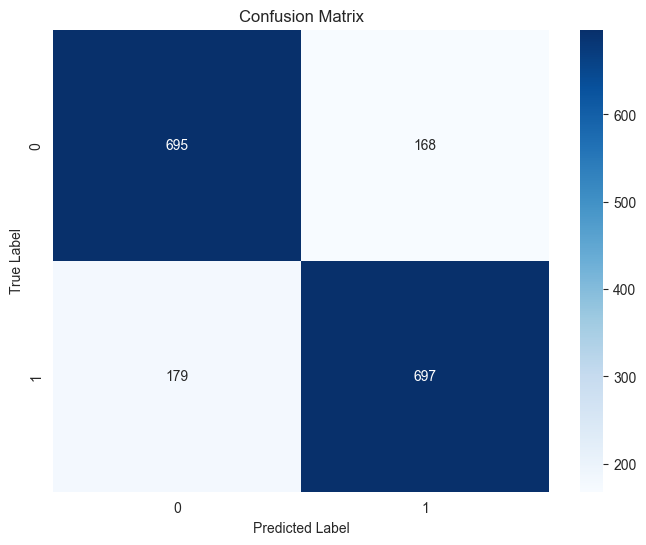

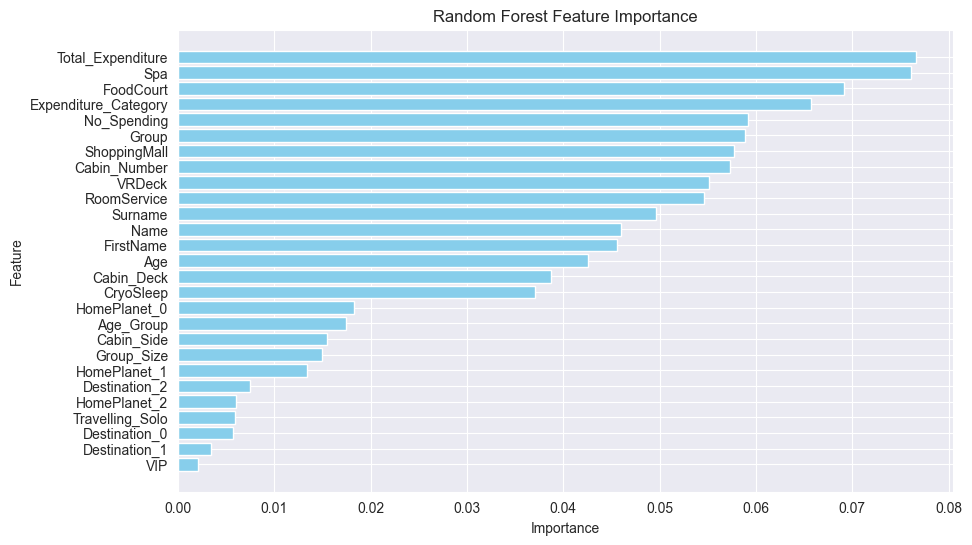

In [38]:
# Define the parameter grid for RandomForest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}
scoring = {'accuracy': make_scorer(accuracy_score), 'f1': make_scorer(f1_score)}
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
# Set up GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2,  scoring=scoring, refit='f1')

# Fit GridSearchCV to find the best parameters
grid_search.fit(X_train, y_train)

# Get the best parameters and best estimator
best_params = grid_search.best_params_
random_forrest = grid_search.best_estimator_

y_pred_best = random_forrest.predict(X_test)
evaluate_model(model = random_forrest, X_test = X_test, y_test = y_test, y_train=y_train, X_train = X_train)

# feature importance 
# Extract feature importances
importances = random_forrest.feature_importances_
feature_importances = pd.DataFrame({
    'Feature': X_train.columns.tolist(),
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature on top
plt.show()

prediction_results(model=random_forrest, test_data = test_data, passenger_ids=passenger_ids)

### 2. Ensemble Methods (Stacking)

This section demonstrates the optimization of top-performing models using hyperparameter tuning and the implementation of a Stacking Classifier to combine their strengths for enhanced predictive performance.

#### Key Steps

- **Hyperparameter Tuning**:
  The `tune_model` function leverages **GridSearchCV** to identify the best hyperparameter configurations through 5-fold cross-validation. This ensures optimized performance for each model by testing various parameter combinations. For the **Random Forest** model, parameters like `n_estimators`, `min_samples_split`, and `max_depth` are tuned. For **LightGBM (LGBM)**, the parameters `n_estimators` and `learning_rate` are optimized.

- **Stacking Ensemble**:
  A Stacking Classifier is implemented, combining the best-tuned **Random Forest** and **LightGBM** models as base estimators. **Logistic Regression** serves as the final estimator, learning from the predictions of the base models. This ensemble method captures the strengths of diverse models, improving generalization and accuracy.

- **Model Evaluation**:
  The stacked model is evaluated using metrics such as accuracy on the test dataset. Additional analysis is performed to understand its predictive capabilities, and predictions are generated for further use.

#### Results
- **Stacked Model Test Accuracy**: Highlights the effectiveness of ensemble learning for achieving higher accuracy and robustness.
- **Prediction Results**: Final predictions from the stacked model are utilized for downstream tasks.

#### Key Benefits
1. **Optimized Performance**: Hyperparameter tuning ensures the best configurations for individual models.
2. **Improved Accuracy**: Stacking combines multiple models, leveraging their strengths to enhance predictive performance.
3. **Comprehensive Evaluation**: Systematic tuning and evaluation provide actionable insights for improved decision-making.
4**Model Diversity**: Using Gradient Boosting, AdaBoost, SVC, and Stacking leverages different algorithms to capture various patterns in the data.

The optimized **Stacking Classifier** achieved the best results, demonstrating improved generalization and reduced overfitting.



[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002751 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2944
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2944
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
[LightGBM] [Info] Numb

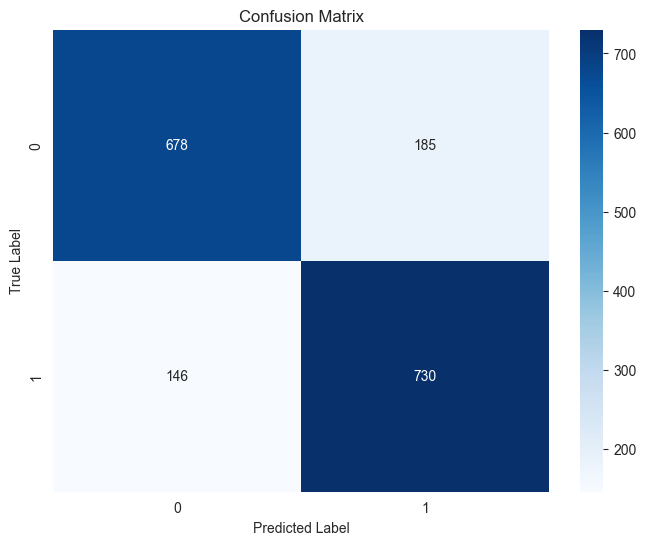

In [39]:
def tune_model(model, params, X, y):
    grid_search = GridSearchCV(model, params, cv=5, n_jobs=-1)
    grid_search.fit(X, y)
    return grid_search.best_estimator_

# Hyperparameter tuning for top models
tuned_rf = tune_model(RandomForestClassifier(), {
    'n_estimators': [100, 200],
    'min_samples_split': [2, 5],
    'max_depth': [10, 15]
}, X_train, y_train)

tuned_lgbm = tune_model(LGBMClassifier(), {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1]
}, X_train, y_train)

# Stacking ensemble
stack = StackingClassifier(estimators=[("RF", tuned_rf), ("LGBM", tuned_lgbm)],
                           final_estimator=LogisticRegression())
stack.fit(X_train, y_train)
print("Stacked Model Test Accuracy:", accuracy_score(y_test, stack.predict(X_test)))

evaluate_model(model=stack, X_test = X_test, y_test = y_test, y_train=y_train, X_train = X_train)
prediction_results(model=stack, test_data = test_data, passenger_ids=passenger_ids)